In [12]:
!pip install datasets

In [2]:
from datasets import load_dataset

ds = load_dataset("mirzaaa10/bengali_sent")
print(ds)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 559
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 120
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 120
    })
})


In [3]:
train_ds = ds["train"]
valid_ds = ds["validation"]
test_ds = ds["test"]

In [15]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['Positive', 'Neutral', 'Negative'], id=None)}

In [16]:
train_ds[1]

{'text': 'সুন্দর লেগেছে ভাল লাগলে কমেন্ট করব', 'label': 0}

In [17]:
len(set(train_ds['label']))

3

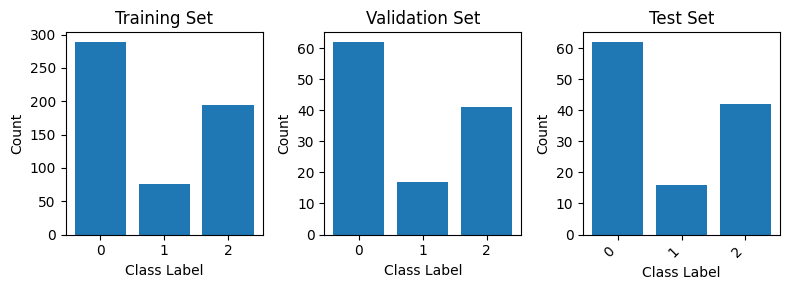

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

train_counts = pd.Series(train_ds["label"]).value_counts()
valid_counts = pd.Series(valid_ds["label"]).value_counts()
test_counts = pd.Series(test_ds["label"]).value_counts()

fig, axes = plt.subplots(1, 3, figsize=(8, 3))

axes[0].bar(train_counts.index, train_counts.values)
axes[0].set_title("Training Set")
axes[0].set_xlabel("Class Label")
axes[0].set_ylabel("Count")

axes[1].bar(valid_counts.index, valid_counts.values)
axes[1].set_title("Validation Set")
axes[1].set_xlabel("Class Label")
axes[1].set_ylabel("Count")

axes[2].bar(test_counts.index, test_counts.values)
axes[2].set_title("Test Set")
axes[2].set_xlabel("Class Label")
axes[2].set_ylabel("Count")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

**Model Training**

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import datasets

In [18]:
def get_model(model_ckpt, num_labels=len(set(train_ds['label']))):
    return AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels)

def get_tokenizer(model_ckpt):
    return AutoTokenizer.from_pretrained(model_ckpt)

In [6]:
def preprocess_function(examples, tokenizer):
    return tokenizer(examples['text'], truncation=True, padding=True, max_length=256)

In [7]:
def compute_metrics(p):
    predictions, labels = p
    preds = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {"accuracy": acc, "f1": f1}

In [8]:
def get_training_args(output_dir="./results", learning_rate=2e-5, batch_size=16, num_train_epochs=3):
    return TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy"
    )

In [9]:
def train_evaluate_model(model_ckpt, train_ds, valid_ds, test_ds, num_labels=3, batch_size=16, num_train_epochs=5):
    model = get_model(model_ckpt, num_labels)
    tokenizer = get_tokenizer(model_ckpt)

    for param in model.parameters():
        if not param.is_contiguous():
            param.data = param.data.contiguous()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_ds = train_ds.map(lambda x: preprocess_function(x, tokenizer), batched=True)
    valid_ds = valid_ds.map(lambda x: preprocess_function(x, tokenizer), batched=True)
    test_ds = test_ds.map(lambda x: preprocess_function(x, tokenizer), batched=True)

    training_args = get_training_args(batch_size=batch_size, num_train_epochs=num_train_epochs)
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=valid_ds,
        compute_metrics=compute_metrics
    )
    trainer.train()
    test_results = trainer.evaluate(test_ds)

    return trainer, test_results

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(trainer, test_dataset, label_names):
    tokenizer = get_tokenizer(model_ckpt)
    test_dataset = test_dataset.map(lambda x: preprocess_function(x, tokenizer), batched=True)
    predictions = trainer.predict(test_dataset)
    y_preds = np.argmax(predictions.predictions, axis=1)

    y_true = np.array(test_dataset['label'])
    cm = confusion_matrix(y_true, y_preds)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

**Training BanglaBert**

In [29]:
model_ckpt = "csebuetnlp/banglabert"
trainer, results = train_evaluate_model(model_ckpt, train_ds, valid_ds, test_ds, num_labels=3)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/120 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.960000,0.927012,0.625000,0.557500
2,0.802300,0.804029,0.700000,0.642513
3,0.673400,0.721252,0.733333,0.679721
4,0.526200,0.692219,0.750000,0.696465
5,0.500200,0.684443,0.741667,0.687692


In [32]:
pd.DataFrame(results, index=[0])

,eval_loss,eval_accuracy,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0.727619,0.708333,0.658995,32.4912,3.693,0.246,5.0


Map:   0%|          | 0/120 [00:00<?, ? examples/s]

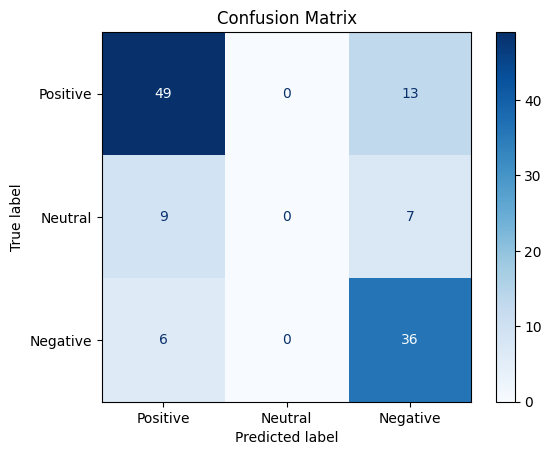

In [46]:
label_names = ["Positive", "Neutral", "Negative"]
plot_confusion_matrix(trainer, test_ds, label_names)

In [ ]:
# 1.  csebuetnlp/banglabert
# 2.  sagorsarker/bangla-bert-base
# 3.  neuralspace/bert-base-multilingual-uncased-sentiment
# 4.  google/muril-base-cased
# 5.  ai4bharat/indic-bert

**Training BanglaBertBase**

In [47]:
model_ckpt = "sagorsarker/bangla-bert-base"
trainer, results = train_evaluate_model(model_ckpt, train_ds, valid_ds, test_ds, num_labels=3)

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/660M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.txt:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/559 [00:00<?, ? examples/s]

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.852100,0.816717,0.616667,0.571295
2,0.634200,0.776457,0.675000,0.638341
3,0.503300,0.796175,0.666667,0.636432
4,0.334400,0.802290,0.675000,0.659829
5,0.299800,0.829541,0.683333,0.665046


In [48]:
pd.DataFrame(results, index=[0])

,eval_loss,eval_accuracy,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0.895148,0.658333,0.61924,44.8672,2.675,0.178,5.0


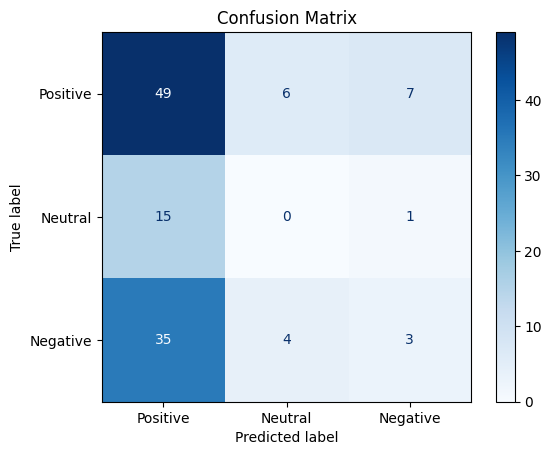

In [49]:
plot_confusion_matrix(trainer, test_ds, label_names)

**Training BertBaseMultilingualUncasedSentiment**

In [51]:
model_ckpt = "google/muril-base-cased"
trainer, results = train_evaluate_model(model_ckpt, train_ds, valid_ds, test_ds, num_labels=3)

config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/953M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/559 [00:00<?, ? examples/s]

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.081600,1.065444,0.516667,0.352015
2,1.032600,1.027282,0.675000,0.619570
3,0.999200,0.994177,0.733333,0.679619
4,0.964400,0.976171,0.741667,0.687484
5,0.957800,0.969496,0.733333,0.680063


In [52]:
pd.DataFrame(results, index=[0])

,eval_loss,eval_accuracy,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0.991859,0.666667,0.619644,36.6377,3.275,0.218,5.0


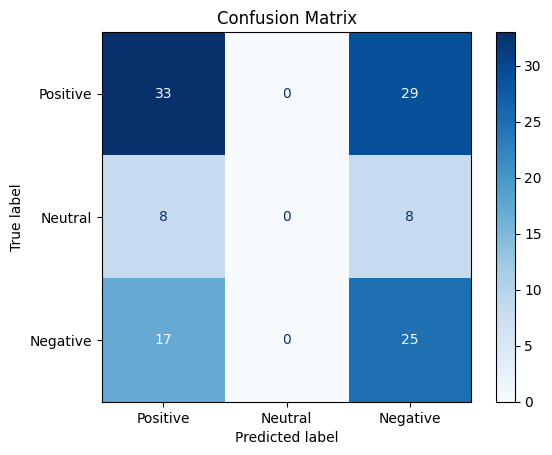

In [53]:
plot_confusion_matrix(trainer, test_ds, label_names)

**Trainning XLM-RoBERTa**

In [11]:
model_ckpt = "xlm-roberta-base"
trainer, results = train_evaluate_model(model_ckpt, train_ds, valid_ds, test_ds, num_labels=3)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/120 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.982100,0.934020,0.633333,0.586597
2,0.897300,0.915853,0.641667,0.573153
3,0.801300,0.779316,0.666667,0.615449
4,0.688000,0.736615,0.716667,0.659469
5,0.657700,0.731247,0.691667,0.636934


In [14]:
pd.DataFrame(results, index=[0])

,eval_loss,eval_accuracy,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0.814372,0.683333,0.632027,52.2973,2.295,0.153,5.0


In [16]:
label_names = ["Positive", "Neutral", "Negative"]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/120 [00:00<?, ? examples/s]

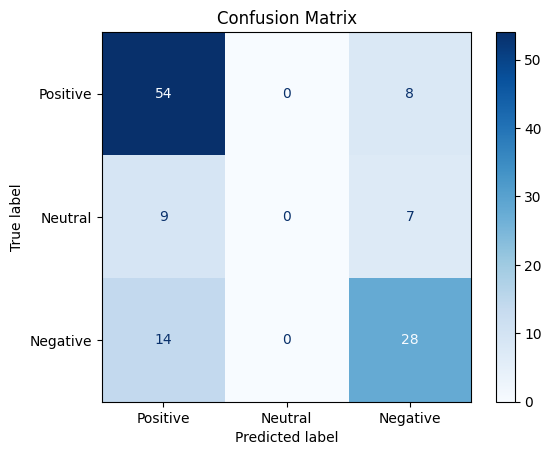

In [22]:
plot_confusion_matrix(trainer, test_ds, label_names)

**Performance Analysis**